In [1]:
import torch
from torch import nn
from torchvision import transforms,datasets
from torch.utils.data import DataLoader

In [2]:
import torch
import torch.nn as nn

class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()

        self.features = nn.Sequential(

            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),


            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),


            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),


            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),


            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


model = VGG16(num_classes=10)
print(sum(p.numel() for p in model.parameters()) / 1e6, "M parameters")


134.301514 M parameters


In [3]:
model

VGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

In [4]:
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters())

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
from typing import Iterator

def train(epochs,model,criterion,optimiser,loader):
  model.to(device)

  for epoch in range(epochs):
    total_loss,total_correct = 0,0
    for images,labels in loader:
      images,labels = images.to(device),labels.to(device)
      y_preds = model(images)
      loss = criterion(y_preds,labels)
      optimiser.zero_grad()
      loss.backward()
      optimiser.step()
      total_loss += loss.item()*(images.size(0))
      total_correct = (y_preds.argmax(1)==labels).sum().item()

    avg_loss = total_loss / len(loader.dataset)
    acc = total_correct / len(loader.dataset)
    print(f"Epoch [{epoch+1}/{epochs}] | Loss: {avg_loss:.4f} | Acc: {acc*100:.2f}%")

In [7]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

train_data = datasets.CIFAR10("./data",train=True,download=True,transform=transform)
test_data = datasets.CIFAR10("./data",train=False,download=True,transform=transform)

print(f"train data length : {len(train_data)}")
print(f"test data length : {len(test_data)}")

100%|██████████| 170M/170M [00:05<00:00, 32.0MB/s]


train data length : 50000
test data length : 10000


In [8]:
from torch.utils.data import Subset

train_data = Subset(train_data,range(0,len(train_data),5))
test_data = Subset(test_data,range(0,len(train_data),5))

train_data_loader = DataLoader(train_data,batch_size=32,shuffle=True)
test_data_loader = DataLoader(test_data,batch_size=32,shuffle=True)

In [9]:
train(3,model,criterion,optim,train_data_loader)

Epoch [1/3] | Loss: 2.3192 | Acc: 0.01%
Epoch [2/3] | Loss: 2.3032 | Acc: 0.00%
Epoch [3/3] | Loss: 2.3028 | Acc: 0.02%


✅ VGG Accuracy: 10.60%


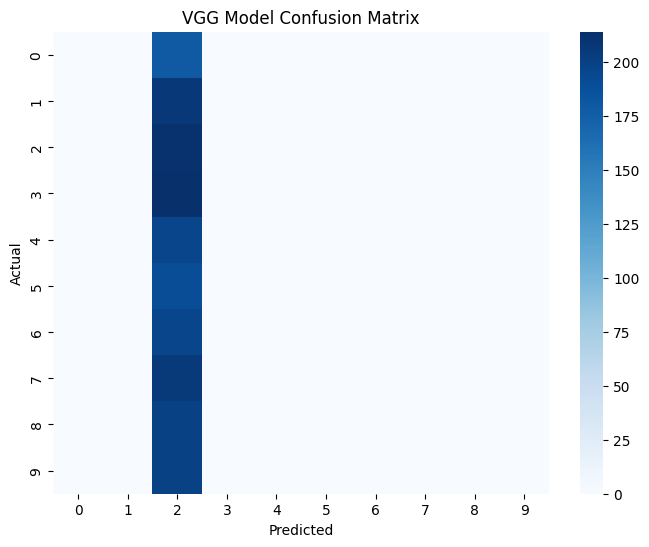

In [11]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate(model, dataloader, name="Model"):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for images, lbls in dataloader:
            images, lbls = images.to(device), lbls.to(device)
            outputs = model(images)
            preds.extend(outputs.argmax(1).cpu().numpy())
            labels.extend(lbls.cpu().numpy())
    acc = accuracy_score(labels, preds)
    print(f"✅ {name} Accuracy: {acc*100:.2f}%")
    return acc, labels, preds


model_acc, model_labels, model_preds = evaluate(model, test_data_loader, "VGG")

cm = confusion_matrix(model_labels, model_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.title("VGG Model Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [12]:
import torch
import torch.nn as nn

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out


In [13]:
class SmallResNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = BasicBlock(64, 64)
        self.layer2 = BasicBlock(64, 128, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.avgpool(out)
        out = torch.flatten(out,1)
        out = self.fc(out)
        return out

resnet = SmallResNet()


Epoch [1/3] | Loss: 2.3357 | Acc: 0.00%
Epoch [2/3] | Loss: 2.3331 | Acc: 0.02%
Epoch [3/3] | Loss: 2.3335 | Acc: 0.03%
✅ Resnet Accuracy: 13.30%


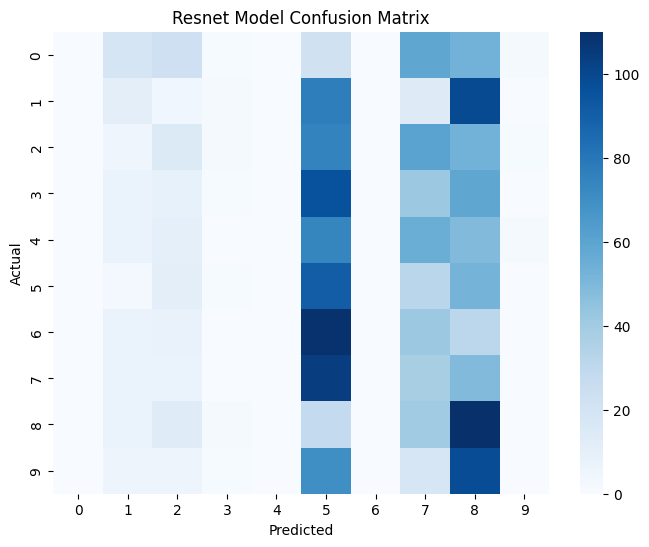

In [14]:
train(3,resnet,criterion,optim,train_data_loader)

model_acc, model_labels, model_preds = evaluate(resnet, test_data_loader, "Resnet")

cm = confusion_matrix(model_labels, model_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.title("Resnet Model Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [15]:
import torch
import torch.nn as nn

class InceptionModule(nn.Module):
    def __init__(self, in_channels, out1, out3red, out3, out5red, out5, outpool):
        super().__init__()

        self.branch1 = nn.Conv2d(in_channels, out1, 1)


        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, out3red, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out3red, out3, 3, padding=1)
        )


        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, out5red, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out5red, out5, 5, padding=2)
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(in_channels, outpool, 1)
        )

    def forward(self, x):
        b1 = self.branch1(x)
        b2 = self.branch2(x)
        b3 = self.branch3(x)
        b4 = self.branch4(x)
        return torch.cat([b1,b2,b3,b4], 1)


In [16]:
class SmallInceptionNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.incep1 = InceptionModule(64, 32, 32, 64, 16, 32, 32)
        self.pool = nn.MaxPool2d(2,2)
        self.incep2 = InceptionModule(160, 64, 32, 64, 16, 32, 32)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(192, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.incep1(x)
        x = self.pool(x)
        x = self.incep2(x)
        x = self.avgpool(x)
        x = torch.flatten(x,1)
        x = self.fc(x)
        return x


inception = SmallInceptionNet()


Epoch [1/3] | Loss: 2.3039 | Acc: 0.02%
Epoch [2/3] | Loss: 2.3039 | Acc: 0.00%
Epoch [3/3] | Loss: 2.3039 | Acc: 0.03%
✅ GoogleLeNet Accuracy: 9.55%


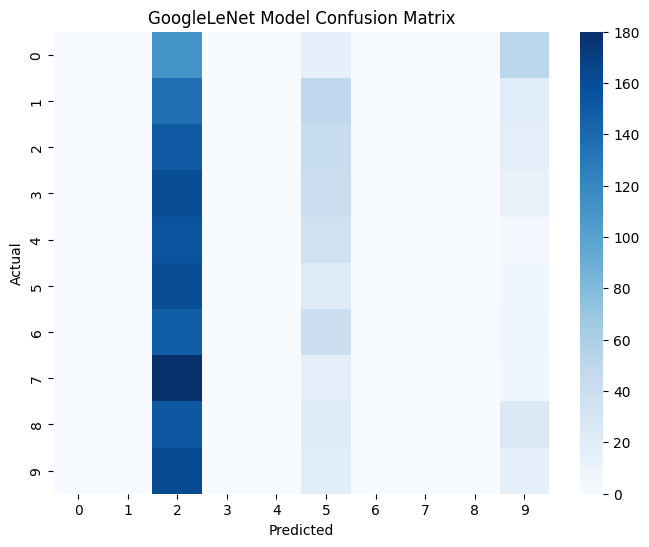

In [17]:
train(3,inception,criterion,optim,train_data_loader)

model_acc, model_labels, model_preds = evaluate(inception, test_data_loader, "GoogleLeNet")

cm = confusion_matrix(model_labels, model_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.title("GoogleLeNet Model Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [18]:
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.depthwise = nn.Conv2d(in_ch, in_ch, kernel_size=kernel_size,
                                   stride=stride, padding=padding, groups=in_ch)
        self.pointwise = nn.Conv2d(in_ch, out_ch, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.relu(x)
        return x

In [19]:
class SmallMobileNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.layer1 = DepthwiseSeparableConv(3, 32)
        self.layer2 = DepthwiseSeparableConv(32, 64)
        self.pool = nn.MaxPool2d(2,2)
        self.layer3 = DepthwiseSeparableConv(64, 128)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.pool(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = torch.flatten(x,1)
        x = self.fc(x)
        return x

mobileNet = SmallMobileNet()


Epoch [1/3] | Loss: 2.3074 | Acc: 0.01%
Epoch [2/3] | Loss: 2.3074 | Acc: 0.02%
Epoch [3/3] | Loss: 2.3074 | Acc: 0.03%
✅ MobileNet Accuracy: 9.85%


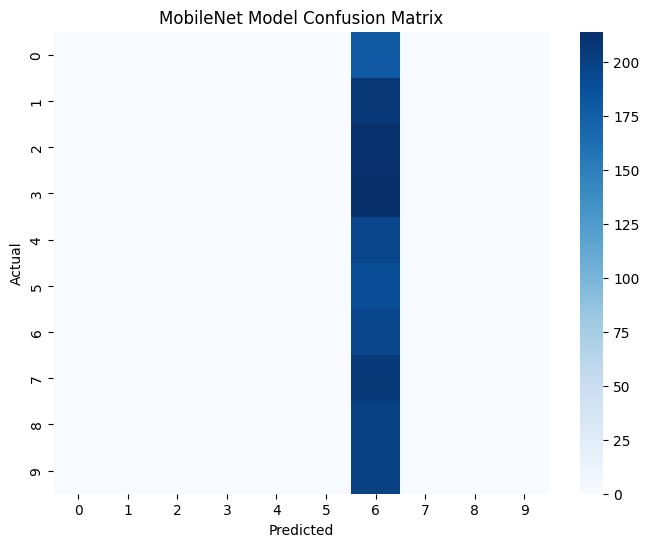

In [20]:
train(3,mobileNet,criterion,optim,train_data_loader)

model_acc, model_labels, model_preds = evaluate(mobileNet, test_data_loader, "MobileNet")

cm = confusion_matrix(model_labels, model_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.title("MobileNet Model Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()